# Efficient Net

In [ ]:
import os
import csv
import numpy as np
import cv2
import scipy

import tensorflow as tf
import keras
import pickle as pkl

import efficientnet.keras as efn
import gc

In [2]:
from keras import backend as K

def fRecall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def fPrecision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def fF1(y_true, y_pred):
    precision = fPrecision(y_true, y_pred)
    recall = fRecall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
val_gen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
strTrainDir = '/project/hackathon/hackers07/shared/patchExtraction/all_train/'
strValDir = '/project/hackathon/hackers07/shared/patchExtraction/all_val/'

In [4]:
# Cear GPU cache if needed i.e. run this before creating new model
keras.backend.clear_session()
gc.collect()

def fMyModel():
    pretrained_model = efn.EfficientNetB4(include_top=False, weights='imagenet', input_shape=(299, 299,3))
    #pretrained_model = keras.applications.resnet50.resnet50(input_shape=(512,512,1), weights=None, include_top = False)
    for layer in pretrained_model.layers:
        layer.trainable = False
    output = pretrained_model.output
    output = keras.layers.GlobalAveragePooling2D()(output)
    
    # customize codes here
    output = keras.layers.core.Dense(700, activation='relu')(output)
    output = keras.layers.Dropout(0.10)(output)
    output = keras.layers.core.Dense(32, activation='relu')(output)
    output = keras.layers.core.Dense(1, activation='sigmoid')(output)
    model = keras.models.Model(inputs=pretrained_model.inputs, outputs=output)
    #model = keras.utils.multi_gpu_model(model, gpus=2)
    
    return model

In [5]:
cModel = fMyModel()
cModel.summary()

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 48) 0           stem_bn[0][0]                    
____

In [6]:
myOptimizer = keras.optimizers.Nadam(lr=0.004)

cModel.compile(optimizer=myOptimizer, loss='binary_crossentropy', metrics=['accuracy',fF1, fPrecision, fRecall])

In [7]:
nTrain = 22449
nVal = 8527

nTrainNoTube=17564
nTrainTube=4882

aClassWeight = [nTrainTube/nTrainNoTube, 1]

In [8]:
for layer in cModel.layers:
    print(layer.output_shape)

(None, 299, 299, 3)
(None, 150, 150, 48)
(None, 150, 150, 48)
(None, 150, 150, 48)
(None, 150, 150, 48)
(None, 150, 150, 48)
(None, 150, 150, 48)
(None, 48)
(None, 1, 1, 48)
(None, 1, 1, 12)
(None, 1, 1, 48)
(None, 150, 150, 48)
(None, 150, 150, 24)
(None, 150, 150, 24)
(None, 150, 150, 24)
(None, 150, 150, 24)
(None, 150, 150, 24)
(None, 24)
(None, 1, 1, 24)
(None, 1, 1, 6)
(None, 1, 1, 24)
(None, 150, 150, 24)
(None, 150, 150, 24)
(None, 150, 150, 24)
(None, 150, 150, 24)
(None, 150, 150, 24)
(None, 150, 150, 144)
(None, 150, 150, 144)
(None, 150, 150, 144)
(None, 75, 75, 144)
(None, 75, 75, 144)
(None, 75, 75, 144)
(None, 144)
(None, 1, 1, 144)
(None, 1, 1, 6)
(None, 1, 1, 144)
(None, 75, 75, 144)
(None, 75, 75, 32)
(None, 75, 75, 32)
(None, 75, 75, 192)
(None, 75, 75, 192)
(None, 75, 75, 192)
(None, 75, 75, 192)
(None, 75, 75, 192)
(None, 75, 75, 192)
(None, 192)
(None, 1, 1, 192)
(None, 1, 1, 8)
(None, 1, 1, 192)
(None, 75, 75, 192)
(None, 75, 75, 32)
(None, 75, 75, 32)
(None, 75,

In [9]:
cHistory = cModel.fit_generator(
    train_gen.flow_from_directory(strTrainDir, target_size=(299,299),class_mode='binary'),
    validation_data=val_gen.flow_from_directory(strValDir, target_size=(299,299), class_mode='binary'),
    steps_per_epoch=nTrain//32,
    epochs=1,
    verbose=1,
    validation_steps=nVal//32,
    class_weight=aClassWeight
)

Found 22449 images belonging to 2 classes.
Found 8527 images belonging to 2 classes.
Epoch 1/1
701/701 [==============================] - 270s 385ms/step - loss: 0.4182 - acc: 0.8216 - fF1: 0.4199 - fPrecision: 0.6813 - fRecall: 0.3360 - val_loss: 0.6952 - val_acc: 0.6291 - val_fF1: 0.4282 - val_fPrecision: 0.3176 - val_fRecall: 0.7131


In [10]:
a=train_gen.flow_from_directory(strTrainDir, target_size=(299,299),class_mode='binary')
a1,y1=next(a)
cModel.predict(a1),y1

Found 22449 images belonging to 2 classes.


(array([[0.4617074 ],
        [0.03549125],
        [0.7128468 ],
        [0.10476284],
        [0.3666908 ],
        [0.72609127],
        [0.517044  ],
        [0.3252698 ],
        [0.90309566],
        [0.06300806],
        [0.35169566],
        [0.70173365],
        [0.37746364],
        [0.9694905 ],
        [0.7650016 ],
        [0.6211511 ],
        [0.6393842 ],
        [0.0093362 ],
        [0.89975864],
        [0.0473269 ],
        [0.5082213 ],
        [0.20985083],
        [0.10300253],
        [0.49687433],
        [0.49753994],
        [0.46442285],
        [0.6053124 ],
        [0.6139815 ],
        [0.19252428],
        [0.21806848],
        [0.99887663],
        [0.8639037 ]], dtype=float32),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       dtype=float32))

In [11]:
for layer in cModel.layers:
    layer.trainable = True

In [12]:
from keras.callbacks import ModelCheckpoint
myOptimizer = keras.optimizers.Nadam(lr=0.00004)

cCallback=ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

cModel.compile(optimizer=myOptimizer, loss='binary_crossentropy', metrics=['accuracy',fF1, fPrecision, fRecall])

In [13]:
cHistory = cModel.fit_generator(
    train_gen.flow_from_directory(strTrainDir, target_size=(299,299),class_mode='binary'),
    validation_data=val_gen.flow_from_directory(strValDir, target_size=(299,299),class_mode='binary'),
    steps_per_epoch=nTrain//16,
    epochs=100,
    verbose=1,
    validation_steps=nVal//16,
    class_weight=aClassWeight,
    callbacks=[cCallback]
)

Found 22449 images belonging to 2 classes.
Found 8527 images belonging to 2 classes.
Epoch 1/100
1403/1403 [==============================] - 1297s 924ms/step - loss: 0.1870 - acc: 0.9246 - fF1: 0.7919 - fPrecision: 0.8881 - fRecall: 0.7454 - val_loss: 0.1444 - val_acc: 0.9541 - val_fF1: 0.8687 - val_fPrecision: 0.9379 - val_fRecall: 0.8295
Epoch 2/100
1403/1403 [==============================] - 1243s 886ms/step - loss: 0.0642 - acc: 0.9771 - fF1: 0.9421 - fPrecision: 0.9573 - fRecall: 0.9381 - val_loss: 0.1625 - val_acc: 0.9575 - val_fF1: 0.8845 - val_fPrecision: 0.9270 - val_fRecall: 0.8631
Epoch 3/100
1403/1403 [==============================] - 1251s 892ms/step - loss: 0.0306 - acc: 0.9894 - fF1: 0.9723 - fPrecision: 0.9746 - fRecall: 0.9753 - val_loss: 0.2007 - val_acc: 0.9579 - val_fF1: 0.8786 - val_fPrecision: 0.9314 - val_fRecall: 0.8498
Epoch 4/100
1403/1403 [==============================] - 1291s 920ms/step - loss: 0.0192 - acc: 0.9933 - fF1: 0.9827 - fPrecision: 0.9835 - f

KeyboardInterrupt: 

In [14]:
cModel.save('/project/hackathon/hackers07/shared/cEfficientNetB4.h5')

In [15]:
a=train_gen.flow_from_directory(strTrainDir, target_size=(299,299),class_mode='binary')
a1,y1=next(a)
b=cModel.predict(a1)

Found 22449 images belonging to 2 classes.


In [16]:
for i in range(len(y1)):
    print(b.flatten()[i], y1[i])

0.99999356 1.0
1.0 1.0
0.9999999 1.0
1.0 1.0
4.5557798e-09 0.0
1.78047e-08 0.0
2.9864165e-15 0.0
8.2638174e-08 0.0
1.0 1.0
1.5481148e-16 0.0
1.0 1.0
1.854298e-11 0.0
1.0 1.0
1.3649129e-11 0.0
6.262371e-18 0.0
1.0 1.0
1.0 1.0
4.2735125e-12 0.0
4.2148e-12 0.0
3.111558e-16 0.0
6.244797e-08 0.0
8.8452926e-12 0.0
0.9999999 1.0
1.0 1.0
1.02946776e-10 0.0
3.7028313e-14 0.0
5.7674283e-18 0.0
1.9395779e-14 0.0
1.7740282e-07 0.0
4.657843e-09 0.0
1.1807527e-09 0.0
3.3400405e-10 0.0


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
dHist=cModel.history.history

In [20]:
dHist

{'val_loss': [0.14444748910576913,
  0.16247746029135832,
  0.2006679924278399,
  0.18741113397489034,
  0.18725755956484932,
  0.23688953037218113,
  0.23385765087393062,
  0.24091671541546433,
  0.26459227082936804,
  0.2609573216868375,
  0.25921742782636586,
  0.29680873740288244,
  0.30510433021847155,
  0.27636184103330574,
  0.2981084025528442,
  0.3220538151185838,
  0.27512415484492886,
  0.2707264647011929,
  0.31243770686812644,
  0.3413903184492211,
  0.3121065546047597,
  0.3413568899420891,
  0.2999696818978741,
  0.3270132265397421,
  0.3010941629474645,
  0.32004482056867806,
  0.3033187610598036,
  0.3124963342476761,
  0.28016840957411826,
  0.30671759279679967],
 'val_acc': [0.9540777327018054,
  0.9575044143684055,
  0.9579164214419084,
  0.961330194245934,
  0.9639199529134785,
  0.9614479105391174,
  0.9618599176126202,
  0.9641553855208946,
  0.9608004708792477,
  0.9634490877021544,
  0.9642731018351274,
  0.9618599175985874,
  0.9609181871689229,
  0.9647439670

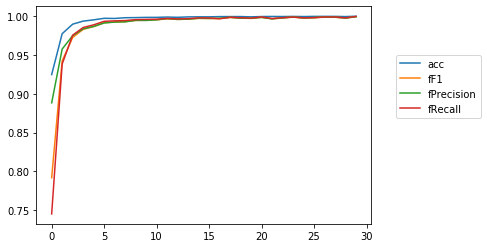

In [45]:
lsValues=[]
fig = plt.figure()
ax = plt.subplot(111)
for sKey in dHist.keys():
    if not 'val' in sKey and 'loss' not in sKey:
        ax.plot(range(len(dHist[sKey])), dHist[sKey], label=sKey)
        lsValues.append(sKey)
    else:
        continue
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.8))
plt.show()

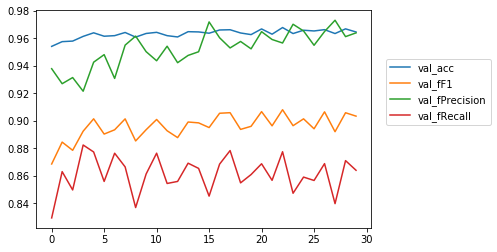

In [44]:
lsValues=[]
fig = plt.figure()
ax = plt.subplot(111)
for sKey in dHist.keys():
    if 'val' in sKey and 'loss' not in sKey:
        ax.plot(range(len(dHist[sKey])), dHist[sKey], label=sKey)
        lsValues.append(sKey)
    else:
        continue
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.8))
plt.show()